In [ ]:
!pip install torch transformers datasets gensim scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install transformers[torch] accelerate -U
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 35.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


In [ ]:
import pandas as pd
from datasets import Dataset, load_metric, load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import accelerate
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score
import transformers
from transformers import get_linear_schedule_with_warmup
from google.colab import drive
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import re
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix,ConfusionMatrixDisplay, classification_report
from collections import Counter
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, AutoConfig, EarlyStoppingCallback, get_scheduler
gc.collect()
print(gensim.__version__)
drive.mount('/content/drive')


4.3.2
Mounted at /content/drive


##Preprocess Dataset and Word Embedding

In [ ]:
df_health = pd.read_csv('HealthNews.csv')
df_politic = pd.read_csv('PoliticNews.csv')

In [ ]:
print(df_health.dtypes)
print(df_politic.dtypes)

content    object
Label       int64
dtype: object
content    object
Label       int64
dtype: object


In [ ]:
print(df_health.isnull().sum())
print(df_politic.isnull().sum())

content    0
Label      0
dtype: int64
content    0
Label      0
dtype: int64


In [ ]:
word_embeddings = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)

# Get the shape of word embeddings
embedding_dimension = word_embeddings.vectors.shape[1]

print("Word Embedding Dimension:", embedding_dimension)

Word Embedding Dimension: 300


In [ ]:
df_train_health,df_test_health = train_test_split(df_health, test_size=0.2 ,random_state=42)
df_eval_health, df_test_health = train_test_split(df_test_health, test_size = 0.1, random_state=42)

In [ ]:
df_train_politic,df_test_politic = train_test_split(df_politic, test_size=0.2 ,random_state=42)
df_eval_politic, df_test_politic = train_test_split(df_test_politic, test_size = 0.1, random_state=42)

In [ ]:
print(f'Total Train: {len(df_train_health)}')
print(f'Total Val  : {len(df_eval_health)}')
print(f'Total Test : {len(df_test_health)}')

Total Train: 4000
Total Val  : 900
Total Test : 100


In [ ]:
print(f'Total Train: {len(df_train_politic)}')
print(f'Total Val  : {len(df_eval_politic)}')
print(f'Total Test : {len(df_test_politic)}')

Total Train: 4000
Total Val  : 900
Total Test : 100


In [ ]:
df_train_health.to_csv("train_health.csv", index=False)
df_eval_health.to_csv("eval_health.csv", index=False)
df_test_health.to_csv("test_health.csv", index=False)

In [ ]:
df_train_politic.to_csv("train_politic.csv", index=False)
df_eval_politic.to_csv("eval_politic.csv", index=False)
df_test_politic.to_csv("test_politic.csv", index=False)

In [ ]:
files_health = {
    "train": "train_health.csv",
    "eval": "eval_health.csv",
    "test": "test_health.csv",
}

dataset_health = load_dataset('csv', data_files=files_health)

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
files_politic = {
    "train": "train_politic.csv",
    "eval": "eval_politic.csv",
    "test": "test_politic.csv",
}

dataset_politic = load_dataset('csv', data_files=files_politic)

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

##Implementation

In [ ]:
# Define a filter function to check if content is a string
def filter_non_strings(example):
    return isinstance(example['content'], str)

dataset_politic = dataset_politic.filter(filter_non_strings)
dataset_health = dataset_health.filter(filter_non_strings)

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/900 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/900 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
# Load the accuracy metric
accuracy_metric = load_metric("accuracy")

# Function to compute accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {'accuracy': accuracy['accuracy']}

In [ ]:
# Initialize BERT tokenizer and model
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
config = AutoConfig.from_pretrained(bert_model_name, num_labels=2)
model = BertForSequenceClassification.from_pretrained(bert_model_name, config=config)
# Increase dropout rate
model.bert.encoder.layer[0].attention.self.dropout.p = 0.3  # Adjust as needed
model.bert.encoder.layer[0].output.dropout.p = 0.3  # Adjust as needed

# Prepare a new embedding layer (This step is conceptual and for illustration)
# In practice, this direct replacement might not align with BERT's tokenization and usage
#embedding_matrix = torch.zeros((len(tokenizer), word_embeddings.vector_size))

# Attempt to assign Word2Vec vectors to the new embedding matrix, aligning by token
#for word, idx in tokenizer.get_vocab().items():
#   if word in word_embeddings:
#        embedding_matrix[idx] = torch.tensor(word_embeddings[word], dtype=torch.float32)

# Replace BERT's word embedding layer with the new embedding matrix
#model.bert.embeddings.word_embeddings = torch.nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [ ]:
def tokenizer_transformer(examples):
    # Filter out non-string entries
    valid_contents = [content for content in examples["content"] if isinstance(content, str)]
    valid_labels = [label for content, label in zip(examples["content"], examples["Label"]) if isinstance(content, str)]

    # Perform tokenization only on valid string content
    encoding = tokenizer(valid_contents, padding='max_length', max_length=256, truncation=True, return_tensors="pt")

    print(f"Input IDs shape: {encoding['input_ids'].shape}")
    print(f"Attention Mask shape: {encoding['attention_mask'].shape}")

    labels = torch.tensor(valid_labels)
    print(f"Labels shape: {labels.shape}, First label: {labels[0]}")  # Debugging labels

    result = {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'labels': labels
    }
    if 'token_type_ids' in encoding:
        result['token_type_ids'] = encoding['token_type_ids']

    return result


# Apply the transformation to your dataset
tokenized_datasets_politic = dataset_politic.map(tokenizer_transformer, batched = True)
tokenized_datasets_health = dataset_health.map(tokenizer_transformer, batched = True)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 0
Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 1
Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 0
Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 1


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Input IDs shape: torch.Size([900, 256])
Attention Mask shape: torch.Size([900, 256])
Labels shape: torch.Size([900]), First label: 0


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Input IDs shape: torch.Size([100, 256])
Attention Mask shape: torch.Size([100, 256])
Labels shape: torch.Size([100]), First label: 1


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 1
Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 1
Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 1
Input IDs shape: torch.Size([1000, 256])
Attention Mask shape: torch.Size([1000, 256])
Labels shape: torch.Size([1000]), First label: 0


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Input IDs shape: torch.Size([900, 256])
Attention Mask shape: torch.Size([900, 256])
Labels shape: torch.Size([900]), First label: 0


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Input IDs shape: torch.Size([100, 256])
Attention Mask shape: torch.Size([100, 256])
Labels shape: torch.Size([100]), First label: 0


In [ ]:
train_datasets_health = tokenized_datasets_health["train"]
test_datasets_health = tokenized_datasets_health["test"]
eval_datasets_health = tokenized_datasets_health["eval"]

In [ ]:
train_datasets_politic = tokenized_datasets_politic["train"]
test_datasets_politic = tokenized_datasets_politic["test"]
eval_datasets_politic = tokenized_datasets_politic["eval"]

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
if torch.cuda.is_available():
    print("A GPU device is available.")
else:
    print("No GPU device is available. Training will default to CPU.")

A GPU device is available.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    warmup_ratio=0.1,
    num_train_epochs=5,
    greater_is_better=True,
    metric_for_best_model='accuracy',
    gradient_accumulation_steps=4,
    fp16=True,
    load_best_model_at_end = True
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_datasets_health,
    eval_dataset=eval_datasets_health,
    compute_metrics=compute_metrics,
    tokenizer = tokenizer
    )
transformers.logging.set_verbosity_info()

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Label, content. If Label, content are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 4,000
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 1,250
  Number of trainable parameters = 109,483,778


Epoch,Training Loss,Validation Loss,Accuracy
1,0.049300,0.018243,0.994444
2,0.041700,0.019696,0.993333
3,0.000300,0.011906,0.997778
4,0.000200,0.014125,0.997778
5,0.000200,0.013889,0.997778


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Label, content. If Label, content are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 900
  Batch size = 4
Saving model checkpoint to ./results/checkpoint-250
Configuration saved in ./results/checkpoint-250/config.json
Model weights saved in ./results/checkpoint-250/model.safetensors
tokenizer config file saved in ./results/checkpoint-250/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-250/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Label, content. If Label, content are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num ex

TrainOutput(global_step=1250, training_loss=0.0343524009168148, metrics={'train_runtime': 478.4447, 'train_samples_per_second': 41.802, 'train_steps_per_second': 2.613, 'total_flos': 2631110553600000.0, 'train_loss': 0.0343524009168148, 'epoch': 5.0})

In [ ]:
trainer.evaluate(eval_datasets_politic)

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Label, content. If Label, content are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 900
  Batch size = 4


{'eval_loss': 4.399662494659424,
 'eval_accuracy': 0.4066666666666667,
 'eval_runtime': 4.3069,
 'eval_samples_per_second': 208.965,
 'eval_steps_per_second': 52.241,
 'epoch': 5.0}

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Label, content. If Label, content are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 100
  Batch size = 4


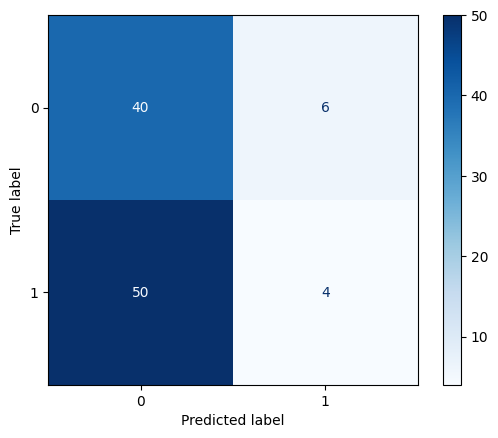

In [ ]:
import matplotlib.pyplot as plt
# Make predictions on the evaluation dataset
predictions, label_ids, metrics = trainer.predict(test_datasets_politic)

# Convert raw logits to predicted labels
predicted_labels = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(label_ids, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()



In [ ]:
# Print the classification report
report = classification_report(label_ids, predicted_labels, target_names=["Fake News", "Not Fake News"])
print("Classification Report:\n", report)

# Print the metrics
print(metrics)

Classification Report:
                precision    recall  f1-score   support

    Fake News       0.44      0.87      0.59        46
Not Fake News       0.40      0.07      0.12        54

     accuracy                           0.44       100
    macro avg       0.42      0.47      0.36       100
 weighted avg       0.42      0.44      0.34       100

{'test_loss': 4.344992160797119, 'test_accuracy': 0.44, 'test_runtime': 0.5539, 'test_samples_per_second': 180.539, 'test_steps_per_second': 45.135}


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_datasets_politic,
    eval_dataset=eval_datasets_politic,
    compute_metrics=compute_metrics,
    tokenizer = tokenizer
)


Using auto half precision backend


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Label, content. If Label, content are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 4,000
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 1,250
  Number of trainable parameters = 109,483,778


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000500,0.017019,0.997778
2,0.000300,0.022523,0.996667
3,0.000100,0.018587,0.997778
4,0.000100,0.020171,0.996667
5,0.000100,0.021929,0.996667


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Label, content. If Label, content are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 900
  Batch size = 4
Saving model checkpoint to ./results/checkpoint-250
Configuration saved in ./results/checkpoint-250/config.json
Model weights saved in ./results/checkpoint-250/model.safetensors
tokenizer config file saved in ./results/checkpoint-250/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-250/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Label, content. If Label, content are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num ex

TrainOutput(global_step=1250, training_loss=0.11146185989379882, metrics={'train_runtime': 484.275, 'train_samples_per_second': 41.299, 'train_steps_per_second': 2.581, 'total_flos': 2631110553600000.0, 'train_loss': 0.11146185989379882, 'epoch': 5.0})

In [ ]:
trainer.evaluate(eval_datasets_politic)

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Label, content. If Label, content are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 900
  Batch size = 4


{'eval_loss': 0.017019005492329597,
 'eval_accuracy': 0.9977777777777778,
 'eval_runtime': 4.2237,
 'eval_samples_per_second': 213.082,
 'eval_steps_per_second': 53.27,
 'epoch': 5.0}

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Label, content. If Label, content are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 100
  Batch size = 4


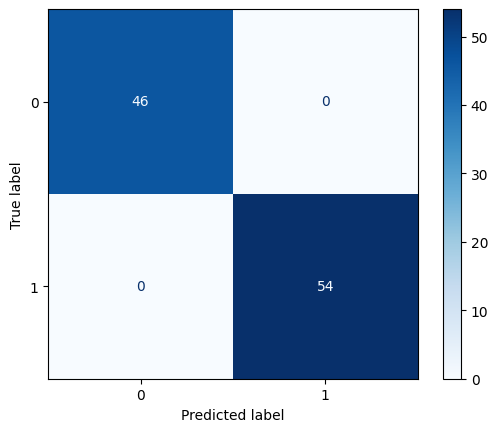

In [ ]:
# Make predictions on the evaluation dataset
predictions, label_ids, metrics = trainer.predict(test_datasets_politic)

# Convert raw logits to predicted labels
predicted_labels = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(label_ids, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()



In [ ]:
# Print the classification report
report = classification_report(label_ids, predicted_labels, target_names=["Fake News", "Not Fake News"])
print("Classification Report:\n", report)

# Print the metrics
print(metrics)

Classification Report:
                precision    recall  f1-score   support

    Fake News       1.00      1.00      1.00        46
Not Fake News       1.00      1.00      1.00        54

     accuracy                           1.00       100
    macro avg       1.00      1.00      1.00       100
 weighted avg       1.00      1.00      1.00       100

{'test_loss': 0.00039469002513214946, 'test_accuracy': 1.0, 'test_runtime': 0.5182, 'test_samples_per_second': 192.989, 'test_steps_per_second': 48.247}
